# Informatics Collaboration Network

In this notebook, we create and visualise three different models of the informatics network:
- [InfNet](#Simple-collaboration-network) : everyone in the School
- [InfNet(6yr)](#6yr-model): network based on the publications from 2012-2017
- [Weighted InfNet(6yr)](#Weighted-6yr-Model) : network weighted by the number of collaboration between nodes

## Setup `pd_poinf` 
(lookup table for people of informatics)

In [ ]:
# %load_ext autoreload
# %autoreload 2
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import cPickle as pkl
# from numpy.random import RandomState # random_state for networkX only for python3.6
# rng = RandomState(787351)

In [2]:
pd_poinf = pd.read_pickle('../data/lookup_poinf.pkl')

In [3]:
# Only need the institute_clas and id:
pd_poinf.drop(
    labels=['last_name', 'first_name', 'institute', 'alias'],
    inplace=True,
    axis=1)

In [4]:
pd_poinf.head(3)

,perseonal_url,position,parent,full_name,institute_class
id,,,,,
23d17ab4-123f-4929-9373-763bd7587df8,http://www.research.ed.ac.uk/portal/en/persons...,visitor official visitor,school of informatics,alay ozgu,0
d089bb44-7d0b-4b3f-b556-27def993d1d1,http://www.research.ed.ac.uk/portal/en/persons...,lecturer in artificial intelligence,school of informatics,albrecht stefano,1
ecd799fb-4f63-44ae-a078-b009099f2c8c,http://www.research.ed.ac.uk/portal/en/persons...,research fellow,school of informatics,alex beatrice,2


In [5]:
institutes = pkl.load(open('../data/institutes.pkl'))

In [6]:
# the class label for each institute:
institutes

{'UNKNOWN': 0,
 'centre for intelligent systems and their applications': 1,
 'deanery of clinical sciences': 8,
 'edinburgh neuroscience': 9,
 'institute for adaptive and neural computation': 4,
 'institute for computing systems architecture': 5,
 'institute of language cognition and computation': 2,
 'institute of perception action and behaviour': 7,
 'laboratory for foundations of computer science': 3,
 'neuroinformatics dtc': 6,
 'school of philosophy psychology and language sciences': 10}

In [7]:
# separate the individuals by community:
infcommunity = {}
gb = pd_poinf.groupby('institute_class')
# Number of individuals in each classes:
for k, group in gb:
    infcommunity[k] = group
    className = [name for (name, _k) in institutes.items() if _k == k][0]
    print('class {}-{}: {}'.format(k, className, len(group)))

class 0-UNKNOWN: 49
class 1-centre for intelligent systems and their applications: 23
class 2-institute of language cognition and computation: 62
class 3-laboratory for foundations of computer science: 62
class 4-institute for adaptive and neural computation: 30
class 5-institute for computing systems architecture: 28
class 6-neuroinformatics dtc: 16
class 7-institute of perception action and behaviour: 19
class 8-deanery of clinical sciences: 1
class 9-edinburgh neuroscience: 1
class 10-school of philosophy psychology and language sciences: 1


The class distribution is uneven! Class 1,2,3,4,5,6,7 are the institutes in the school of informatics. Additional classes are found, but they are relatively small, except for the UNKNOWN class which contains individuals who's institutes are not present.

In [8]:
# Create a color map for each institute:
inst_by_color = {
    0: 'xkcd:silver',
    1: 'xkcd:cyan',
    2: 'xkcd:magenta',
    3: 'xkcd:indigo',
    4: 'xkcd:red',
    5: 'xkcd:lime',
    6: 'xkcd:goldenrod',
    7: 'xkcd:azure',
    8: 'xkcd:lavender',
    9: 'xkcd:grey green',
    10: 'xkcd:coral',
    'others': 'xkcd:claret'
}

In [9]:
print('Number of individuals in informatics:', len(pd_poinf))

Number of individuals in informatics: 292


# Simple collaboration network

This section, we only consider a simple undirected of the informatics collaboration network

## Setup

In [10]:
# Import the dataset for publication:
lookup_pub = pd.read_pickle(path='../data/lookup_pub.pkl')

In [11]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

In [12]:
print('total number of edges: ', len(all_edges))

total number of edges:  59522


In [13]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges = set()
for (i1,i2) in all_edges:
    assert i1 != i2, "SELF LOOPS DETECTED!"
    
    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2,i1) in unique_edges: 
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges.add((i1,i2))

In [14]:
print('number of unique edge pairs: ', len(unique_edges))

number of unique edge pairs:  35866


In [15]:
# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf_id = set(pd_poinf.index)
poinf_edges_only = [(au1, au2) for (au1, au2) in unique_edges
                    if au1 in poinf_id and au2 in poinf_id]

In [16]:
print('size of collaboration network (number of edges): ', len(poinf_edges_only))

size of collaboration network (number of edges):  474


### Graphing infnet

In [17]:
g_poinf_only = nx.from_edgelist(poinf_edges_only)
# this is the pos for the entire network! we can use this to maintain the visualiation across different experiements
pos = nx.spring_layout(g_poinf_only)

In [18]:
# light up the nodes based on the institutes they belong to:
def color_by_inst(g):
    node_color = []
    for node in g:
        node_color.append(inst_by_color[int(pd_poinf.institute_class.loc[[str(node)]])])
    return node_color

In [19]:
def add_inst_labels(ax, with_legend=True):
    for label in institutes.values():
        ax.scatter(
            [0], [0],
            color=inst_by_color[label],
            label=[name for (name, _k) in institutes.items() if _k == label][0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.scatter([0],[0], color='white', s=100, edgecolors='none')
    return ax

You can include the label but uncommenting `ax = add_inst_label(ax)`

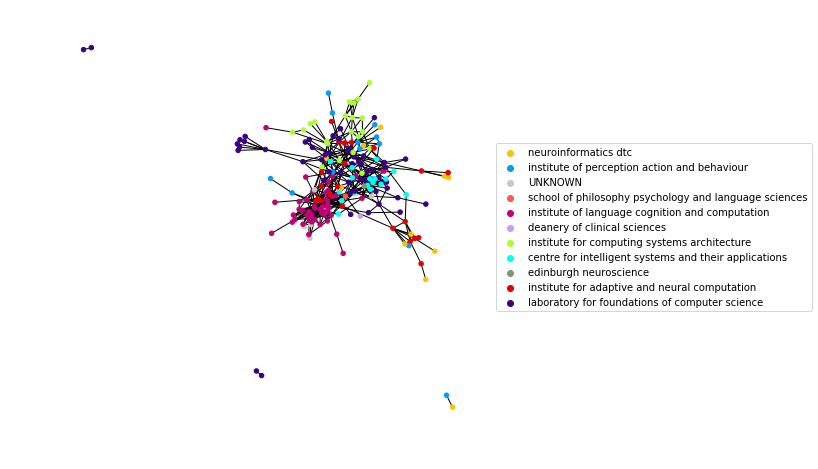

In [20]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(g_poinf_only))
plt.savefig("IMG/infnet.pdf", format='pdf', bbox_inches="tight")

In [21]:
print(nx.info(g_poinf_only))

Name: 
Type: Graph
Number of nodes: 190
Number of edges: 474
Average degree:   4.9895


## Statistics

In [22]:
from helper import * # Helper functions!

### Degree distribution

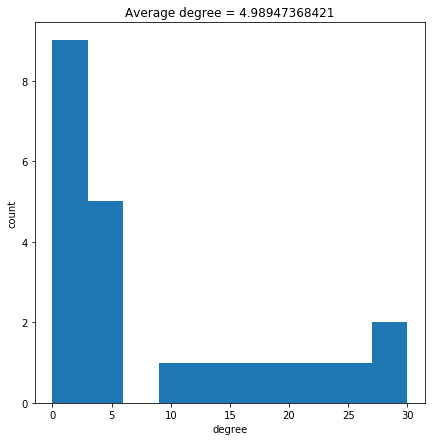

In [23]:
ax, degree_seq = degree_dist(g_poinf_only)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/goweiting/miniconda3/envs/infnet/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


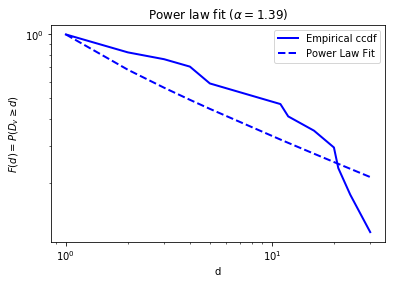

In [24]:
# we can observe the power-law fit to our degree distribution:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
plt.savefig("IMG/infnet_degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

ideally, a log-log plot on the ccdf with power-law should yield a straight line

### Clustering coefficients

In [25]:
cc = clustering_coeff(g_poinf_only)

In [26]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.364537637285


In [27]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only)
print('Transitivity:',transitivity_graph)

Transitivity: 0.302419354839


### Connected components

In [28]:
gccs, percentage = generateGCC(g_poinf_only)

component 1: 96.84%
component 2: 1.05%
component 3: 1.05%
component 4: 1.05%


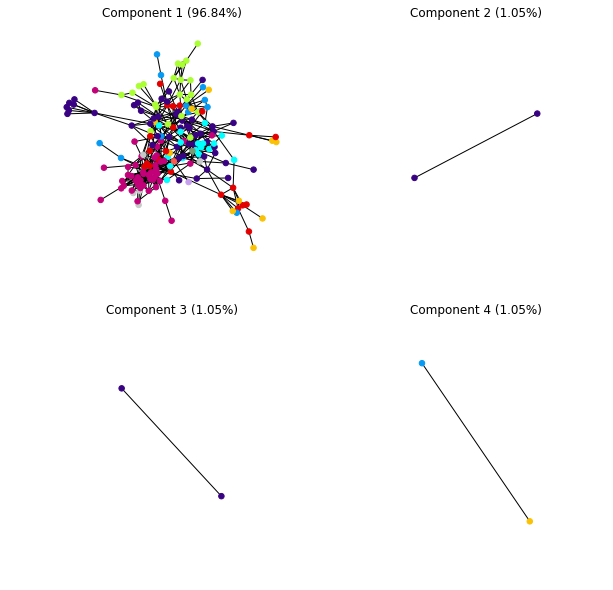

In [29]:
# display the connected components:
fig = plt.figure(figsize=(10,10))
num_col = len(gccs)/2
for i, g in enumerate(gccs,1):
    percent = percentage[i-1]
    ax = fig.add_subplot(num_col,2,i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=30,
        pos=pos)
plt.savefig("IMG/infnet_CC.pdf", format='pdf', 
            bbox_inches="tight")

## Giant Connected Component
Now, we analyse the giant connected component from the network

In [30]:
main_gcc = gccs[0] # First element is our GCC as we have sorted in reverse
pos_gcc = nx.spring_layout(main_gcc)

In [31]:
print('number of nodes in largest connected component:', len(main_gcc))

number of nodes in largest connected component: 184


In [32]:
print(nx.info(main_gcc))

Name: 
Type: Graph
Number of nodes: 184
Number of edges: 471
Average degree:   5.1196


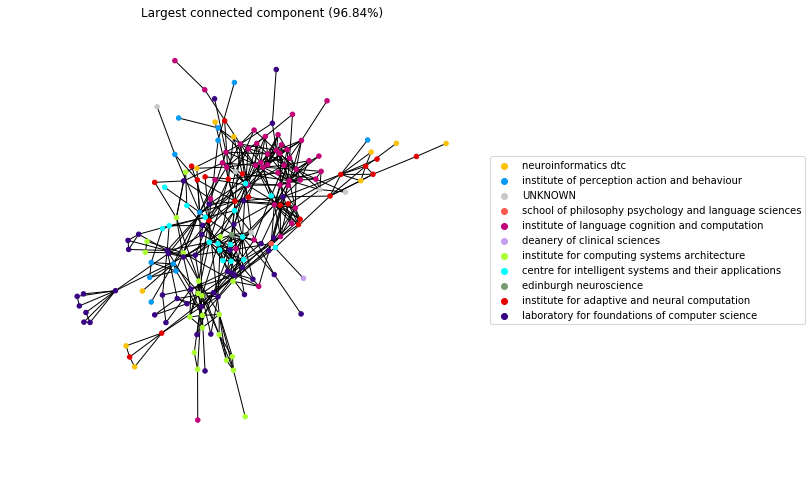

In [33]:
# Draw the Network
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(main_gcc)
)
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]));
plt.savefig("IMG/infnet_LargestCC.pdf", format='pdf', 
            bbox_inches="tight")

### Degree Distribution

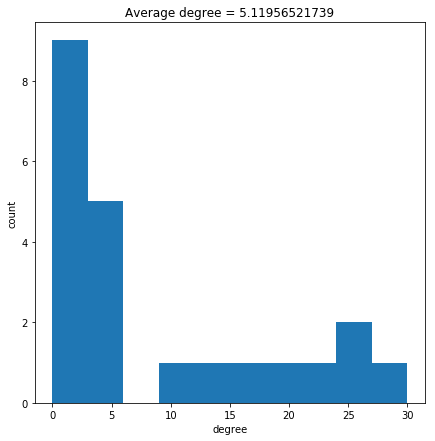

In [34]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/goweiting/miniconda3/envs/infnet/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


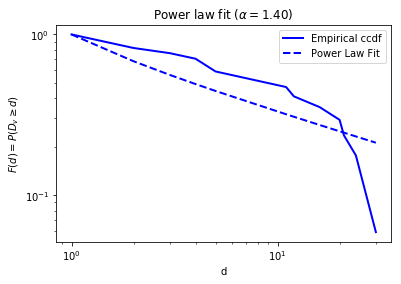

In [35]:
fig = power_law_fit(degree_seq)
plt.savefig("IMG/infnet_LargestCC-degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

### Clustering Coefficient

In [36]:
cc = clustering_coeff(main_gcc)

In [37]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.376424734153


### Average Path & Diameter

In [38]:
nx.average_shortest_path_length(main_gcc) # AVERAGE PATH

3.940306486101212

In [39]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 10


### Community detection

In [40]:
import community

In [41]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]  
# assign each node to the community they belong to

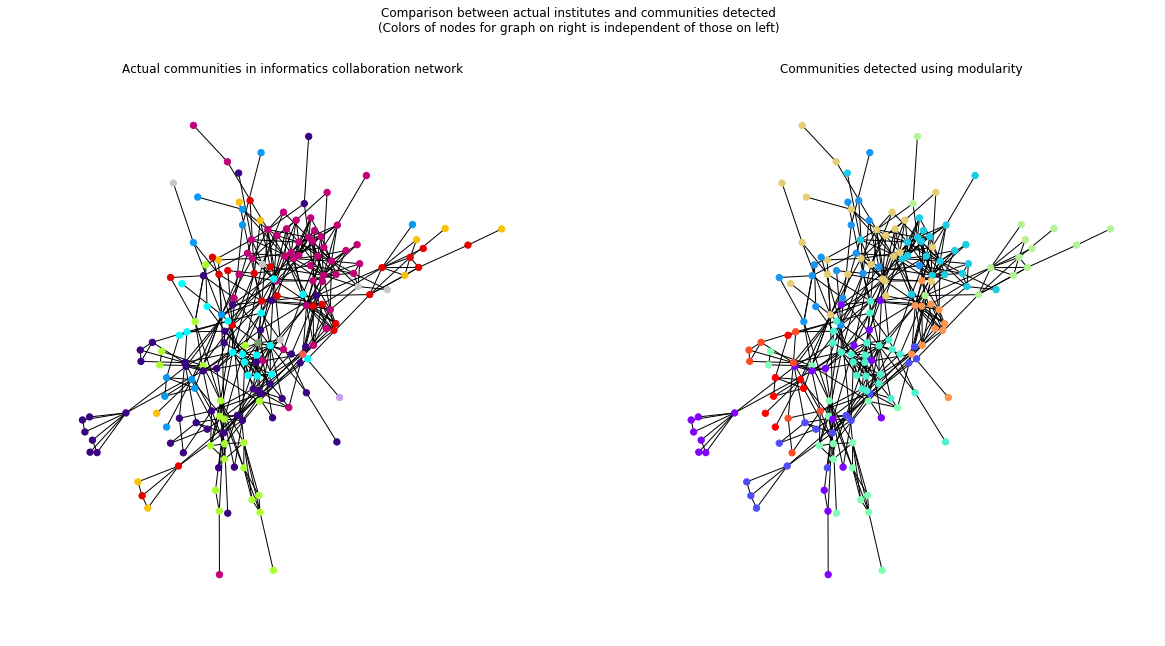

In [42]:
# Plot the networks side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)')
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)
ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig("IMG/infnet_LargestCC_commCompare.pdf", format='pdf', 
            bbox_inches="tight")

In [43]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

Number of communities detected = 11


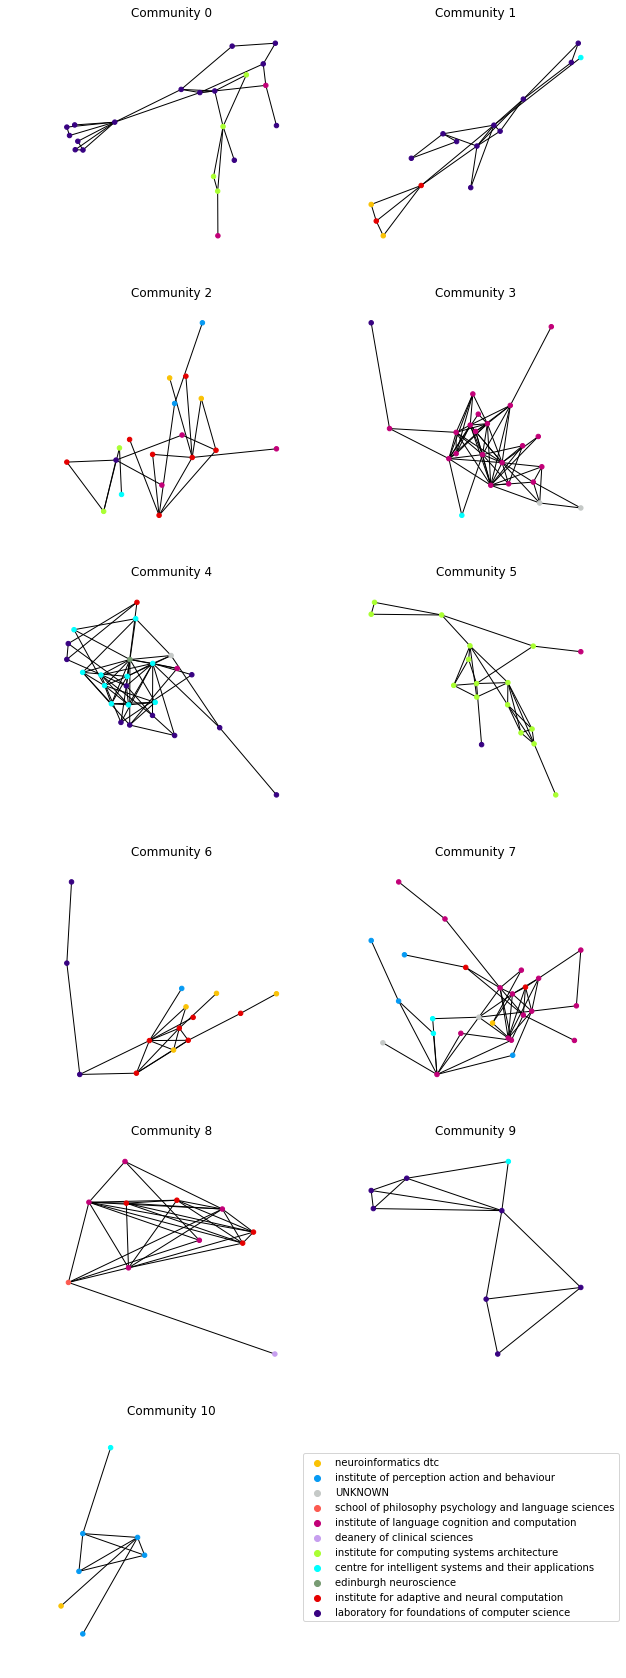

In [44]:
# plot each community:
fig = plt.figure(figsize=(10,30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6,2,i)
    # find those nodes belonging to this community:
    nodes_from_comm = [node_id for (node_id, c) in parts.items() if c == comm_id]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=20,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig("IMG/infnet_LargestCC_communities.pdf", format='pdf', 
            bbox_inches="tight")

### Influential individuals
Using betweness centrality as a mean to measure influence of node in the network

In [45]:
bt = between_parallel(main_gcc)

In [46]:
top = 11

In [47]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [48]:
max_nodes = sorted(bt.iteritems(), key=lambda v: -v[1])[:top]
max_nodes

[('2b36a690-b726-438e-8eb7-1128a7e7775d', 0.11067695494581109),
 ('9cb66eca-0de2-438b-8896-9c5d6d748601', 0.09931078756812355),
 ('bfb547ed-a4df-4a6c-b1be-8ecd9b13419f', 0.09911870547111072),
 ('0e635bd1-f0fb-4f16-a68a-d0457b80eed7', 0.09298357982286781),
 ('3593b144-170a-4242-90cf-16ffbe82f45f', 0.09075749235849732),
 ('90396347-473b-4fba-8b1d-a1d25ea18b6b', 0.08597531169417638),
 ('da3124d7-44f9-4199-82bf-9e964f422ab9', 0.08093255731980996),
 ('053590d0-39d7-4a42-b42d-61ee8d743d3e', 0.07329369568540593),
 ('8e51eafb-dd78-468b-8970-ec2349e92305', 0.07262444005144705),
 ('ee01bccc-c4d2-45f8-a81c-9c634464a623', 0.07262441546011025),
 ('f53b1ad8-3f19-4e7e-8a3a-f7996de038c0', 0.07110939204198956)]

In [49]:
# variables for plotting the network: values tell nx how big each node should be
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 150)**2.2 # SCALE IT ACCORDINGLY
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

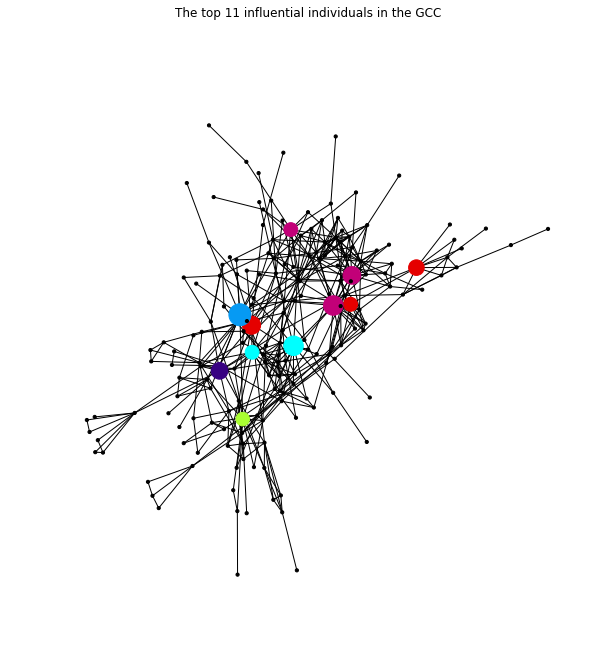

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet_influencer.pdf", format='pdf', 
            bbox_inches="tight")

In [51]:
top_ids = [a[0] for a in max_nodes]

In [52]:
pd_poinf.loc[top_ids]

,perseonal_url,position,parent,full_name,institute_class
id,,,,,
2b36a690-b726-438e-8eb7-1128a7e7775d,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,ramamoorthy ram,7
9cb66eca-0de2-438b-8896-9c5d6d748601,http://www.research.ed.ac.uk/portal/en/persons...,chair of artificial intelligence and head of s...,school of informatics,moore johanna,2
bfb547ed-a4df-4a6c-b1be-8ecd9b13419f,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,bundy alan,1
0e635bd1-f0fb-4f16-a68a-d0457b80eed7,http://www.research.ed.ac.uk/portal/en/persons...,personal chair chair of machine learning,school of informatics,williams christopher,4
3593b144-170a-4242-90cf-16ffbe82f45f,http://www.research.ed.ac.uk/portal/en/persons...,chair of speech technology,school of informatics,renals steve,2
90396347-473b-4fba-8b1d-a1d25ea18b6b,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,buneman peter,3
da3124d7-44f9-4199-82bf-9e964f422ab9,http://www.research.ed.ac.uk/portal/en/persons...,personal chair in systems neurobiology,school of informatics,armstrong douglas,4
053590d0-39d7-4a42-b42d-61ee8d743d3e,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,goddard nigel,4
8e51eafb-dd78-468b-8970-ec2349e92305,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,atkinson malcolm,1


---
# 6yr Model

## Setup `lookup_pub`

In [53]:
# Import the dataset:
lookup_pub = pd.read_pickle(path='../data/lookup_pub.pkl')

In [54]:
# What are the years?
print(sorted(pd.unique(lookup_pub.year),reverse=True))

['8/04/08', '30/03/01', '28/09/05', '28/03/02', '26/03/02', '22/11/10', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '2/07/03', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977', '1976', '1975', '1974', '1973', '1971', '1970', '1969', '1/09/99']


In [55]:
# There are some dates instead of just purely years. 
# they all fall out of the 6 year period that we are interestted in (2017-2012)
# Grouping the publications by year:
gb = lookup_pub.groupby('year')
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print("{}:\t{}".format(yr, len(group)))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [56]:
combined_yrs = pd.concat(pd_years.values())
print("Total publications: ",len(combined_yrs))

Total publications:  3574


In [57]:
all_edges_6yr = []
for listEdges in combined_yrs.edges:
    all_edges_6yr.extend(listEdges)
print('total number of edges: ', len(all_edges_6yr))

total number of edges:  29474


In [58]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges_6yr = set()
for (i1,i2) in all_edges_6yr:
    assert i1 != i2, "SELF LOOPS DETECTED!"
    
    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2,i1) in unique_edges_6yr: 
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges_6yr.add((i1,i2))

In [59]:
print('number of unique edge pairs: ', len(unique_edges_6yr))

number of unique edge pairs:  19605


In [60]:
# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf6yr_edges_only = [(au1, au2) for (au1, au2) in unique_edges_6yr
                    if au1 in poinf_id and au2 in poinf_id]

In [61]:
print('size of collaboration network (number of edges): ', len(poinf6yr_edges_only))

size of collaboration network (number of edges):  355


Note the large decrease in edges with and without external individuals (from 19,605 to 355)

### Graphing Infnet (6yr model)

In [62]:
g_poinf_only_6yr = nx.from_edgelist(poinf6yr_edges_only)
pos_6yr = nx.spring_layout(g_poinf_only_6yr)

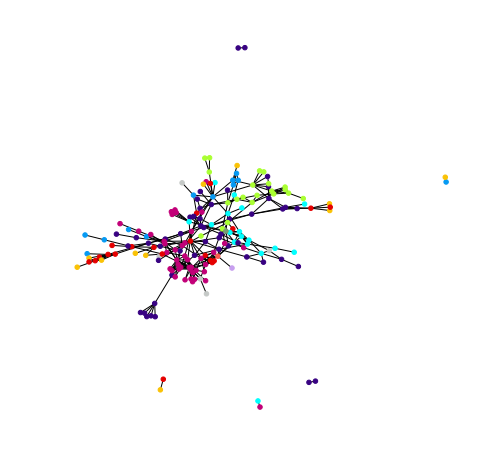

In [63]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only_6yr,
    pos=pos_6yr,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(g_poinf_only_6yr)
)
plt.savefig("IMG/infnet6yr_full_graph.pdf", format='pdf', 
            bbox_inches="tight")

In [64]:
print(nx.info(g_poinf_only_6yr))

Name: 
Type: Graph
Number of nodes: 180
Number of edges: 355
Average degree:   3.9444


## Statistics

### Degree distribution

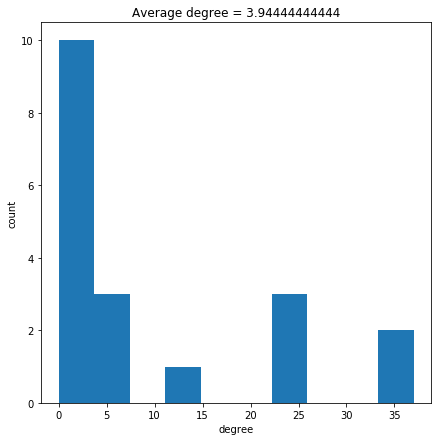

In [65]:
ax, degree_seq = degree_dist(g_poinf_only_6yr)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


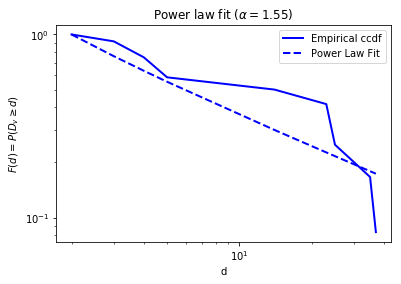

In [66]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
plt.savefig("IMG/infnet6yr_degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

### Clustering coefficient

In [67]:
cc = clustering_coeff(g_poinf_only_6yr)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.421964851597


In [68]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only_6yr)
print('Transitivity:',transitivity_graph)

Transitivity: 0.400434074878


### Connected Components

In [69]:
gccs, percentage = generateGCC(g_poinf_only_6yr)

component 1: 94.44%
component 2: 1.11%
component 3: 1.11%
component 4: 1.11%
component 5: 1.11%
component 6: 1.11%


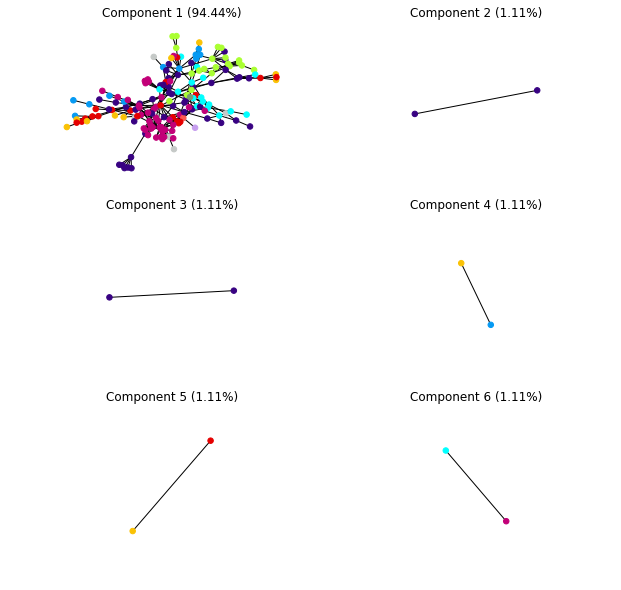

In [70]:
# display the connected components:
fig = plt.figure(figsize=(10,10))
num_col = len(gccs)/2
for i, g in enumerate(gccs,1):
    percent = percentage[i-1]
    ax = fig.add_subplot(num_col,2,i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=30,
        pos=pos_6yr)
plt.savefig("IMG/infnet6yr_CC.pdf", format='pdf', 
            bbox_inches="tight")

## Giant Connected Component

In [71]:
main_gcc = gccs[0]
pos_gcc = nx.spring_layout(main_gcc)

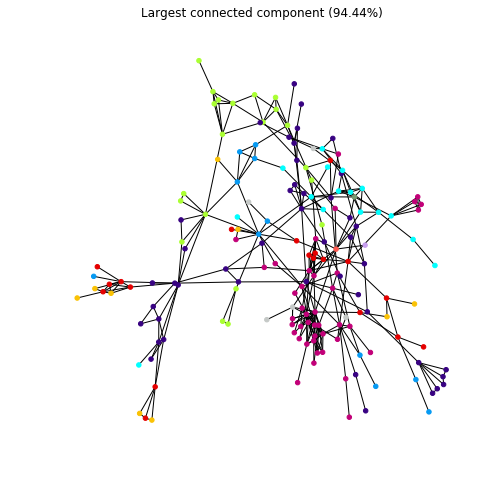

In [72]:
    node_color=color_by_inst(g_poinf_only_6yr)
    node_color=color_by_inst(g_poinf_only_6yr)
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(main_gcc)
)
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]));
plt.savefig("IMG/infnet6yr_LargestCC.pdf", format='pdf', 
            bbox_inches="tight")

In [73]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 170
Name: 
Type: Graph
Number of nodes: 170
Number of edges: 350
Average degree:   4.1176


### Degree distribution

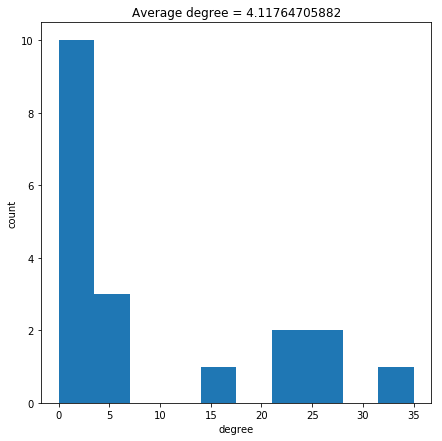

In [74]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


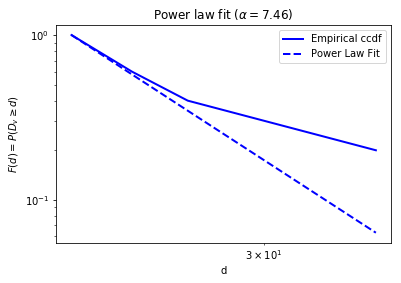

In [75]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
plt.savefig("IMG/infnet6yr_LargestCC_degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

### Clustering Coefficient

In [76]:
cc = clustering_coeff(main_gcc)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.446786313456


### Average Path & Diameter

In [77]:
nx.average_shortest_path_length(main_gcc) # AVERAGE PATH

4.964427427775844

In [78]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 11


### Community detection

In [79]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]  
# assign each node to the community they belong to

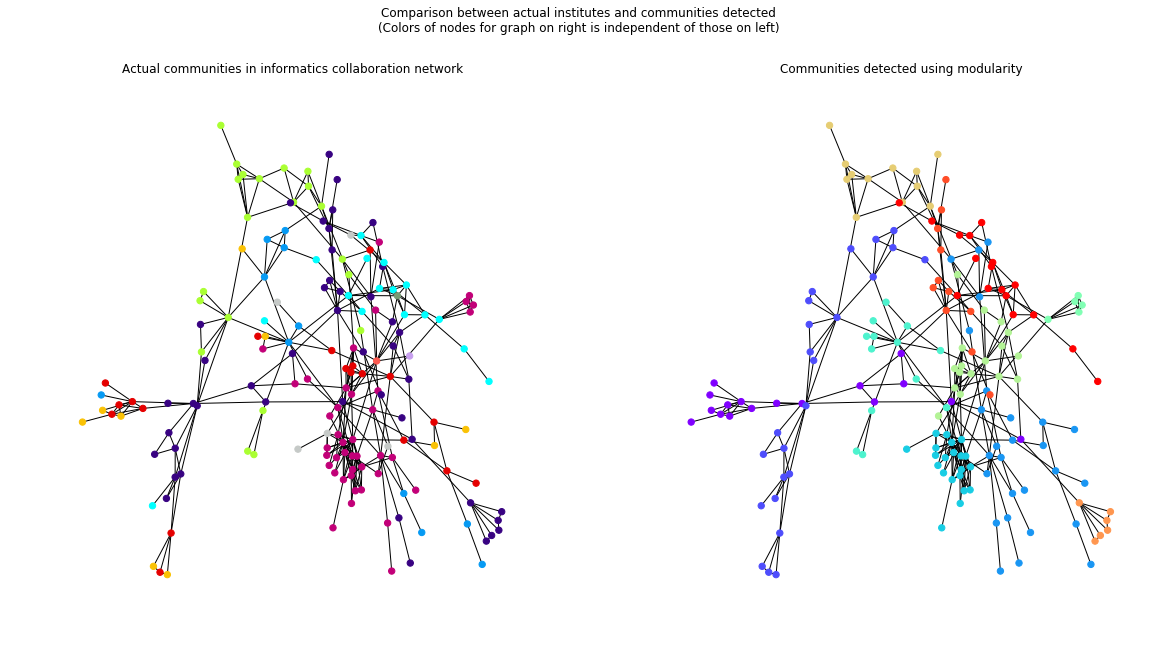

In [80]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)')
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)


ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig("IMG/infnet6yr_LargestCC_commCompare.pdf", format='pdf', 
            bbox_inches="tight")

In [81]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

Number of communities detected = 11


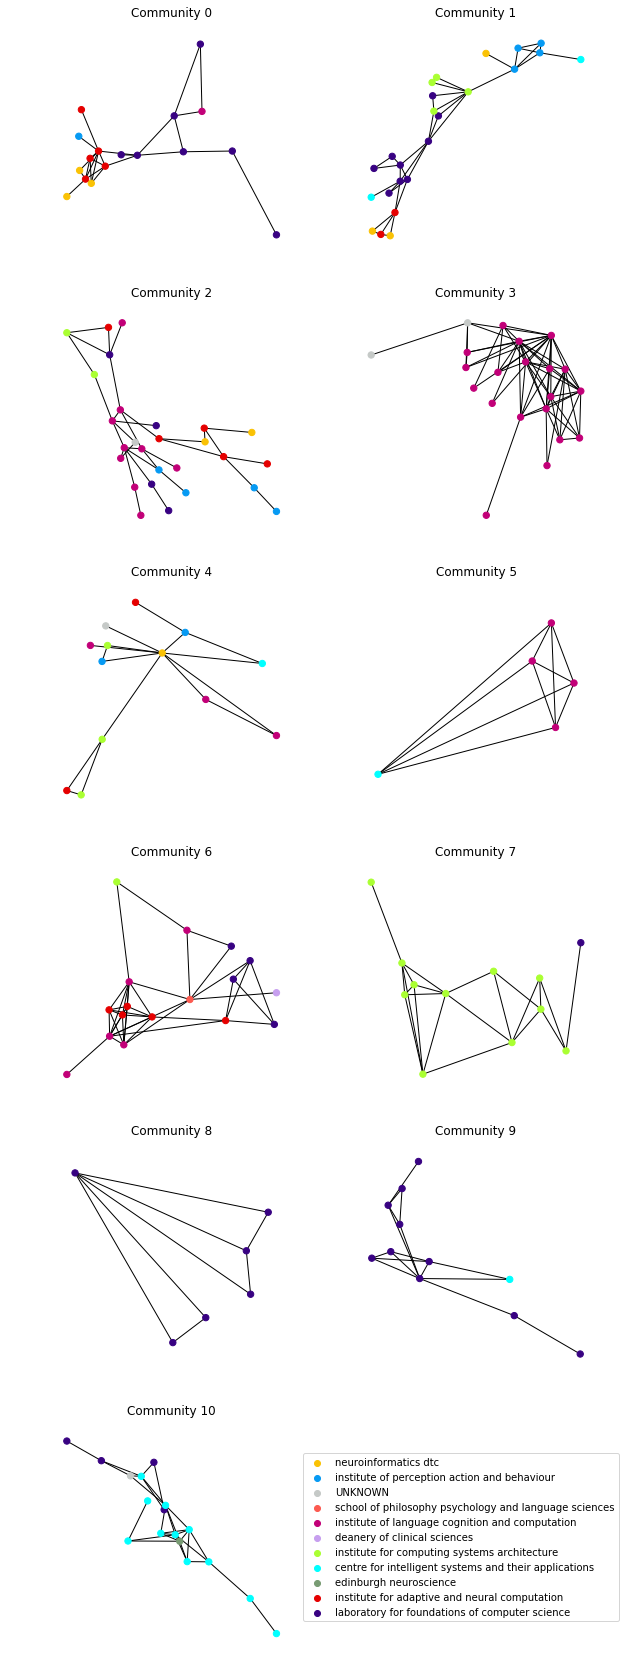

In [82]:
# plot each community:
fig = plt.figure(figsize=(10,30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6,2,i)
    # find those nodes belonging to this community:
    nodes_from_comm = [node_id for (node_id, c) in parts.items() if c == comm_id]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=40,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig("IMG/infnet6yr_LargestCC_communities.pdf", format='pdf', 
            bbox_inches="tight")

### Influential individuals

In [83]:
bt = between_parallel(main_gcc)

In [84]:
top = 11

In [85]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [86]:
max_nodes = sorted(bt.iteritems(), key=lambda v: -v[1])[:top]
max_nodes

[('2b36a690-b726-438e-8eb7-1128a7e7775d', 0.27078475343324176),
 ('f53b1ad8-3f19-4e7e-8a3a-f7996de038c0', 0.19844656322734242),
 ('986afcb2-4d51-4593-97e9-6530894d5c43', 0.16838438505812864),
 ('bd09c3e2-3826-4065-b33c-edc31ce40e15', 0.15237496973674508),
 ('66ef2544-9295-4e01-bc75-49a28d907749', 0.14180948020233733),
 ('1c6a1e04-4291-426e-a921-42be34ba8494', 0.13996266531427473),
 ('15b544ff-f14e-4393-bee6-0aa38f4361b6', 0.12226536693091883),
 ('1a05e95b-6e1a-40d8-8406-d5e62b7c722d', 0.10788292141314118),
 ('ee01bccc-c4d2-45f8-a81c-9c634464a623', 0.10453406742891548),
 ('b8e1d5e4-9bd1-4765-bb06-f72c331a9af5', 0.091405159801653),
 ('3593b144-170a-4242-90cf-16ffbe82f45f', 0.08712302568914819)]

In [87]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 150)**2.2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

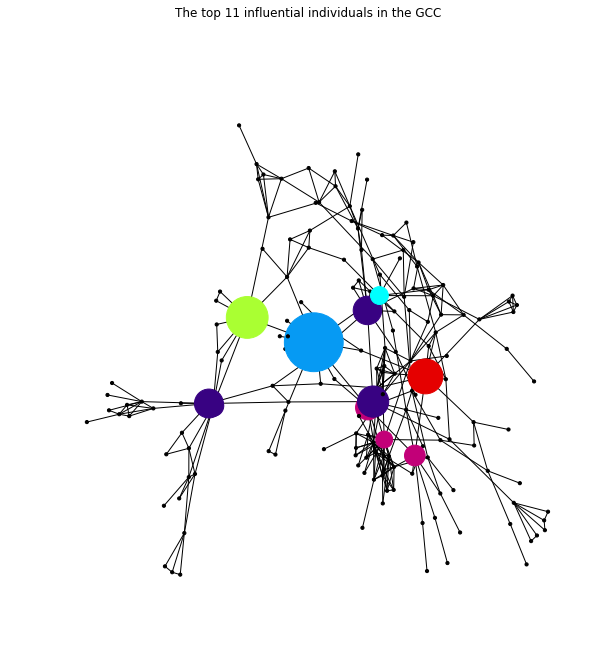

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet6yr_influencer.pdf", format='pdf', 
            bbox_inches="tight")

In [89]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]

,perseonal_url,position,parent,full_name,institute_class
id,,,,,
2b36a690-b726-438e-8eb7-1128a7e7775d,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,ramamoorthy ram,7
f53b1ad8-3f19-4e7e-8a3a-f7996de038c0,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,nagarajan vijay,5
986afcb2-4d51-4593-97e9-6530894d5c43,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,sutton charles,4
bd09c3e2-3826-4065-b33c-edc31ce40e15,http://www.research.ed.ac.uk/portal/en/persons...,research associate,school of informatics,cao yang,3
66ef2544-9295-4e01-bc75-49a28d907749,http://www.research.ed.ac.uk/portal/en/persons...,chair of computational systems biology,school of informatics,danos vincent,3
1c6a1e04-4291-426e-a921-42be34ba8494,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,cheney james,3
15b544ff-f14e-4393-bee6-0aa38f4361b6,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,steedman mark,2
1a05e95b-6e1a-40d8-8406-d5e62b7c722d,http://www.research.ed.ac.uk/portal/en/persons...,research associate,school of informatics,banks chris,3
ee01bccc-c4d2-45f8-a81c-9c634464a623,http://www.research.ed.ac.uk/portal/en/persons...,personal chair in natural language processing,school of informatics,lapata mirella,2


# Weighted 6yr Model
IN this section, we explore a version of the weight simple undirected grap of the 6yr model.
The calculation of the weight of an edge is the sum of contributions by each author pair for all their publications (publication which involve both of them (and others).

Contributions are calculated as $$\text{contribution}(u,v) = \frac{1}{\text{size of complete graph}} = \frac{1}{{N}\choose{2}} = \frac{1}{\frac{N(N-1)}{2}} = \frac{2}{N(N-1)}$$ where $N$ is the number of authors for a publication.

Weight of edge between authors $u$ and $v$ 
$$weight(u,v) = \sum_{i=1}^{N}\text{contribution}_{i}(u,v)$$

## Setup

In [90]:
def get_edge_weight(authors):
    # function to calculate the edge weight for each publication
    if len(authors) > 1:
        n = len(authors)
        k = 2./(n*(n-1))
    else:
        k = 0.
    return k

In [91]:
combined_yrs['weight'] = combined_yrs.apply(lambda row:get_edge_weight(row.collab_id), axis=1 )

In [92]:
combined_yrs.iloc[1]

year                                                       2015
authors       mirjam wester|matthew aylett|marcus tomalin|ra...
shortnames          wester, m.|aylett, m.|tomalin, m. |dall, r.
collab_id     [9bd00432-876e-46f6-af92-26173b891484, 7102181...
edges         [(9bd00432-876e-46f6-af92-26173b891484, 710218...
weight                                                 0.166667
Name: 7f8c35ed-b32c-4fc2-9a90-dc63961a12cb, dtype: object

In [93]:
# Add the edges to the network with weight attribute
g_poinf_weighted = nx.Graph()
for row in combined_yrs.itertuples():
    edgelist = row.edges
    weight = row.weight
    for (a, b) in edgelist:
        if a in poinf_id and b in poinf_id:
            g_poinf_weighted.add_edge(a, b, weight=weight)

In [94]:
edgewidth = [d['weight']*2. for (u, v, d) in g_poinf_weighted.edges(data=True)
             ]  # weights for each edges
print(nx.info(g_poinf_weighted))

Name: 
Type: Graph
Number of nodes: 180
Number of edges: 355
Average degree:   3.9444


In [95]:
assert not set(g_poinf_only_6yr.nodes).difference(
    set(g_poinf_weighted.nodes
        )), "Same number of nodes for both 6yr model should be observer"

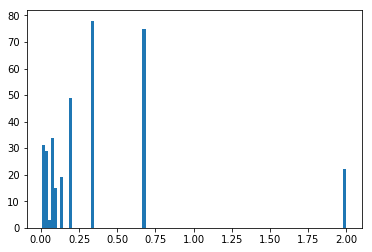

In [96]:
# Take a look at the distribution of edgewidth
plt.hist(
    edgewidth, bins=100)
plt.savefig('IMG/distofWeights.pdf', format='pdf', bbbox_inches="tight")

### Graphing Weighted Network

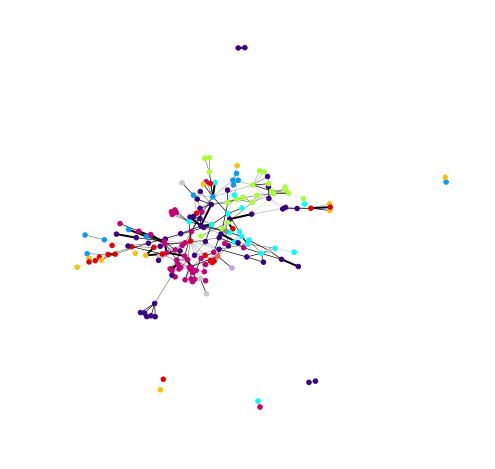

In [97]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    g_poinf_weighted,
    pos=pos_6yr,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(g_poinf_weighted))
nx.draw_networkx_edges(
    g_poinf_weighted,
    pos_6yr,
    width=edgewidth,
)

plt.savefig("IMG/infnetweighted_full_graph.pdf", format='pdf', bbox_inches="tight")

## Statistics
Degree distribution is the same as 3.2.1

### Clustering

In [98]:
print('Average clustering coeff: ', nx.average_clustering(g_poinf_weighted, weight='weight'))

Average clustering coeff:  0.0602758043597


This is lower than the unweighted graph ( 0.421964851597)!

### Connected Components

In [99]:
gccs, percentage = generateGCC(g_poinf_weighted)

component 1: 94.44%
component 2: 1.11%
component 3: 1.11%
component 4: 1.11%
component 5: 1.11%
component 6: 1.11%


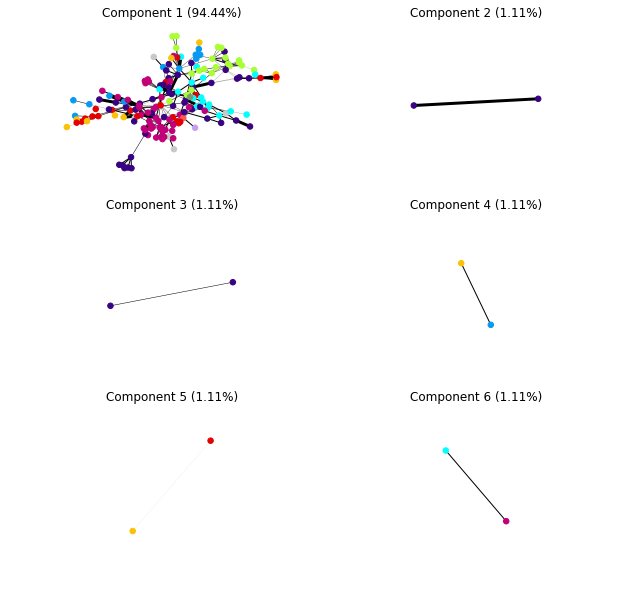

In [100]:
# display the connected components:
fig = plt.figure(figsize=(10,10))
num_col = len(gccs)/2
for i, g in enumerate(gccs,1):
    percent = percentage[i-1]
    ax = fig.add_subplot(num_col,2,i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx_nodes(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=30,
        pos=pos_6yr)
    g_edgewidth = [ d['weight'] for (u,v,d) in g.edges(data=True)]
    nx.draw_networkx_edges(g, pos_6yr, width=np.multiply(g_edgewidth,3))
    
plt.savefig("IMG/infnetweighted_CC.pdf", format='pdf', 
            bbox_inches="tight")

In [101]:
main_gcc = gccs[0]

In [102]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 170
Name: 
Type: Graph
Number of nodes: 170
Number of edges: 350
Average degree:   4.1176


## Giant Connected Component

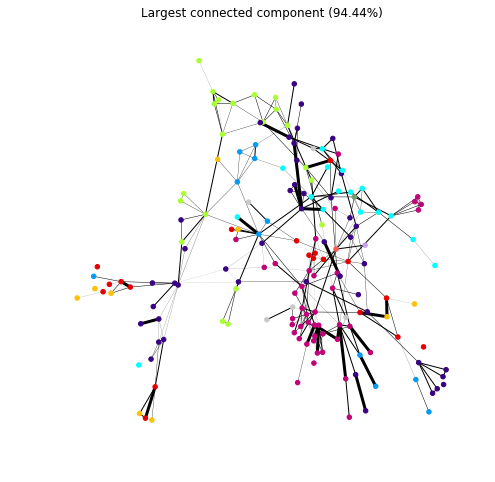

In [103]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(main_gcc)
)
main_gcc_edgewidth = [ d['weight'] for (u,v,d) in main_gcc.edges(data=True)]
nx.draw_networkx_edges(main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth,3))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]));
plt.savefig("IMG/infnetweighted_LargestCC.pdf", format='pdf', 
            bbox_inches="tight")

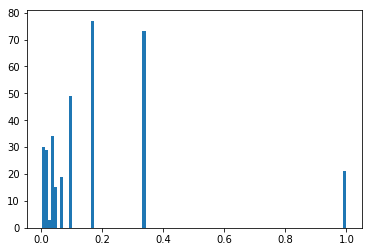

In [104]:
plt.hist(main_gcc_edgewidth,bins=100);

In [105]:
print('Average clustering coeff: ', nx.average_clustering(main_gcc, weight='weight'))

Average clustering coeff:  0.0638214399103


In [106]:
print('Average shortest path length: ', nx.average_shortest_path_length(main_gcc,weight='weight'))

Average shortest path length:  0.703742783796


### Community Detection

In [107]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]  
# assign each node to the community they belong to

In [108]:
print('Number of communities detected: ', len(set(values)))

Number of communities detected:  13


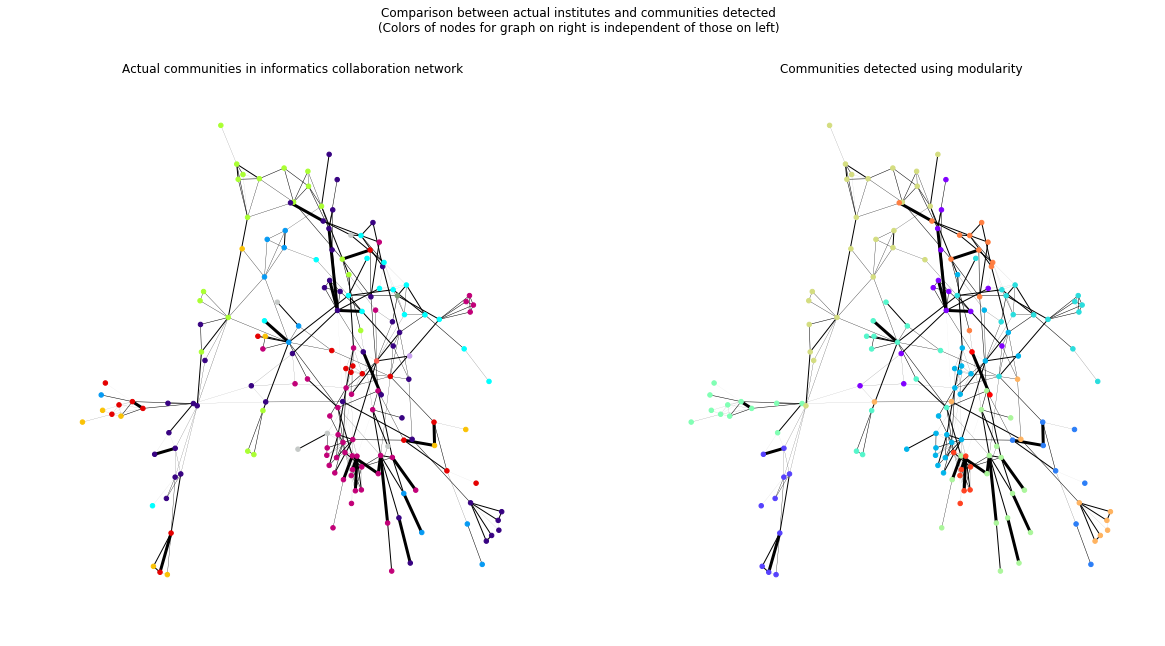

In [109]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)')
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=20,
    node_color=color_by_inst(main_gcc)
)
nx.draw_networkx_edges(main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth,3))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=20,
    with_labels=False)
nx.draw_networkx_edges(main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth,3))
plt.savefig("IMG/infnetweight_LargestCC_commCompare.pdf", format='pdf', 
            bbox_inches="tight")

### Influential Individuals
We use the top scores for the eigenvector centrality to determine who are the most influential individuals

In [110]:
evect_centrality = nx.eigenvector_centrality_numpy(main_gcc, weight='weight')

In [111]:
max_nodes = sorted(evect_centrality.iteritems(), key=lambda v: -v[1])[:top]
max_nodes

[('1c6a1e04-4291-426e-a921-42be34ba8494', 0.67345530806725085),
 ('b707b343-a7ca-4798-ba5c-f5414cf4b9c1', 0.39917307326461554),
 ('ca066cb3-40b1-4721-a12e-edbdb031cf7c', 0.37754438030974369),
 ('f66a2291-496c-4371-a060-ef2d68c379f3', 0.36256584154618909),
 ('62297b26-8314-4d54-950e-4f43a6ea346f', 0.18936075055345028),
 ('e76a7c40-a177-4eb5-9ac3-12ab104895f8', 0.12848142910054253),
 ('8e51eafb-dd78-468b-8970-ec2349e92305', 0.1146196605456649),
 ('90396347-473b-4fba-8b1d-a1d25ea18b6b', 0.11449368180880323),
 ('31e35c9e-6ff7-4978-8422-fd6f0ebaa194', 0.098921170954816867),
 ('3689a744-b724-4631-92b9-58159b762936', 0.08390288231690142),
 ('b8e1d5e4-9bd1-4765-bb06-f72c331a9af5', 0.072847075311708531)]

In [112]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 100)**2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

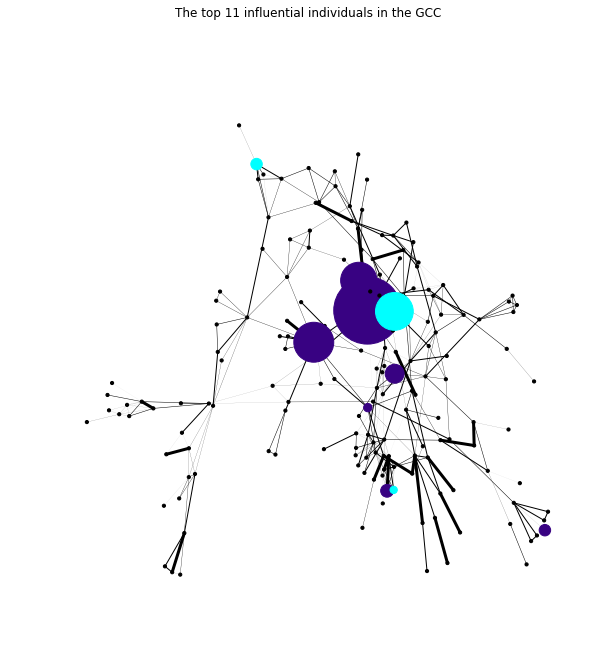

In [113]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
nx.draw_networkx_edges(main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth,3))
plt.savefig("IMG/infnetweight_influencer.pdf", format='pdf', 
            bbox_inches="tight")

In [114]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]

,perseonal_url,position,parent,full_name,institute_class
id,,,,,
1c6a1e04-4291-426e-a921-42be34ba8494,http://www.research.ed.ac.uk/portal/en/persons...,reader,school of informatics,cheney james,3
b707b343-a7ca-4798-ba5c-f5414cf4b9c1,http://www.research.ed.ac.uk/portal/en/persons...,senior research fellow,school of informatics,lindley sam,3
ca066cb3-40b1-4721-a12e-edbdb031cf7c,http://www.research.ed.ac.uk/portal/en/persons...,research fellow,school of informatics,anderson paul,1
f66a2291-496c-4371-a060-ef2d68c379f3,http://www.research.ed.ac.uk/portal/en/persons...,research associate,school of informatics,ricciotti wilmer,3
62297b26-8314-4d54-950e-4f43a6ea346f,http://www.research.ed.ac.uk/portal/en/persons...,chair of theoretical computer science,school of informatics,wadler philip,3
e76a7c40-a177-4eb5-9ac3-12ab104895f8,http://www.research.ed.ac.uk/portal/en/persons...,research associate,school of informatics,perera roland,3
8e51eafb-dd78-468b-8970-ec2349e92305,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,atkinson malcolm,1
90396347-473b-4fba-8b1d-a1d25ea18b6b,http://www.research.ed.ac.uk/portal/en/persons...,professor,school of informatics,buneman peter,3
31e35c9e-6ff7-4978-8422-fd6f0ebaa194,http://www.research.ed.ac.uk/portal/en/persons...,research associate,school of informatics,stolarek jan,3
